In [157]:
import keras

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, SimpleRNN, GRU, Activation

In [159]:
# Data ingestion - reading the datasets from Azure blob 
!wget http://azuremlsamples.azureml.net/templatedata/PM_train.txt 
!wget http://azuremlsamples.azureml.net/templatedata/PM_test.txt
!wget http://azuremlsamples.azureml.net/templatedata/PM_truth.txt

--2021-12-21 09:50:21--  http://azuremlsamples.azureml.net/templatedata/PM_train.txt
Resolving azuremlsamples.azureml.net (azuremlsamples.azureml.net)... 13.107.246.69, 13.107.213.69, 2620:1ec:bdf::69, ...
Connecting to azuremlsamples.azureml.net (azuremlsamples.azureml.net)|13.107.246.69|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3515356 (3.4M) [text/plain]
Saving to: ‘PM_train.txt.6’

PM_train.txt.6      100%[===================>]   3.35M  --.-KB/s    in 0.08s   

2021-12-21 09:50:21 (41.8 MB/s) - ‘PM_train.txt.6’ saved [3515356/3515356]

--2021-12-21 09:50:21--  http://azuremlsamples.azureml.net/templatedata/PM_test.txt
Resolving azuremlsamples.azureml.net (azuremlsamples.azureml.net)... 13.107.246.69, 13.107.213.69, 2620:1ec:bdf::69, ...
Connecting to azuremlsamples.azureml.net (azuremlsamples.azureml.net)|13.107.246.69|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2228855 (2.1M) [text/plain]
Saving to: ‘PM_test.txt.6’

PM_te

In [160]:
# read training data 
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [161]:
# read test data
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [162]:
# read ground truth data
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [163]:
train_df = train_df.sort_values(['id','cycle'])
train_df

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,2388.19,9065.52,1.3,48.07,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,2388.23,9065.11,1.3,48.04,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,2388.24,9065.90,1.3,48.09,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,21.61,550.68,2388.25,9073.72,1.3,48.39,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [164]:
# Data Labeling - generate column RUL
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [165]:
# generate label columns for training data
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0,0


In [166]:
# MinMax normalization
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,1.0,0.726248,0.242424,0.109755,0.0,0.369048,0.633262,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,1.0,0.628019,0.212121,0.100242,0.0,0.380952,0.765458,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,1.0,0.710145,0.272727,0.140043,0.0,0.250000,0.795309,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,1.0,0.740741,0.318182,0.124518,0.0,0.166667,0.889126,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,1.0,0.668277,0.242424,0.149960,0.0,0.255952,0.746269,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


In [167]:
#Next, we prepare the test data. We first normalize the test data using the parameters from the MinMax normalization applied on the training data.
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,1.0,0.652174,0.212121,0.127614,0.0,0.208333,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,1.0,0.805153,0.166667,0.146684,0.0,0.386905,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,1.0,0.685990,0.227273,0.158081,0.0,0.386905,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,1.0,0.679549,0.196970,0.105717,0.0,0.255952,0.573561,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,1.0,0.694042,0.166667,0.102396,0.0,0.273810,0.737740,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108


In [168]:
# Next, we use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

In [169]:
# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,1.0,0.652174,0.212121,0.127614,0.0,0.208333,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,1.0,0.805153,0.166667,0.146684,0.0,0.386905,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,1.0,0.685990,0.227273,0.158081,0.0,0.386905,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,1.0,0.679549,0.196970,0.105717,0.0,0.255952,0.573561,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,1.0,0.694042,0.166667,0.102396,0.0,0.273810,0.737740,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138


In [170]:
# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1,label2
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,1.0,0.652174,0.212121,0.127614,0.0,0.208333,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,1.0,0.805153,0.166667,0.146684,0.0,0.386905,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,1.0,0.685990,0.227273,0.158081,0.0,0.386905,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,1.0,0.679549,0.196970,0.105717,0.0,0.255952,0.573561,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,1.0,0.694042,0.166667,0.102396,0.0,0.273810,0.737740,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0,0


# Modelling

In [171]:
# pick a large window size of 50 cycles
sequence_length = 50

In [172]:
# preparing data for visualizations 
# window of 50 cycles prior to a failure point for engine id 12
engine_id12 = test_df[test_df['id'] == 12]
engine_id12_50cycleWindow = engine_id12[engine_id12['RUL'] <= engine_id12['RUL'].min() + 50]
cols1 = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
engine_id12_50cycleWindow1 = engine_id12_50cycleWindow[cols1]
cols2 = ['s11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
engine_id12_50cycleWindow2 = engine_id12_50cycleWindow[cols2]

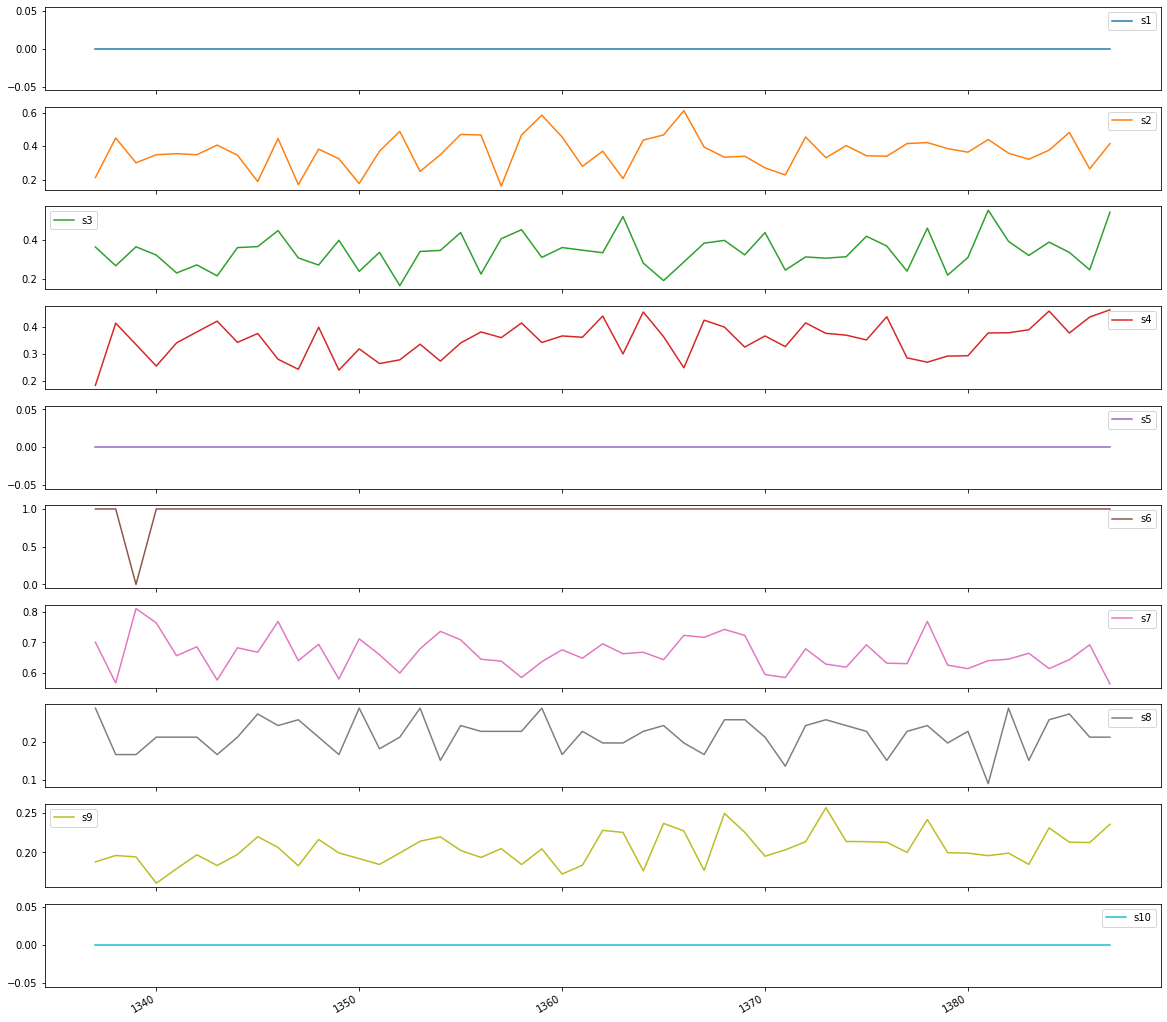

In [173]:
# plotting sensor data for engine ID 12 prior to a failure point - sensors 1-10 
ax1 = engine_id12_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

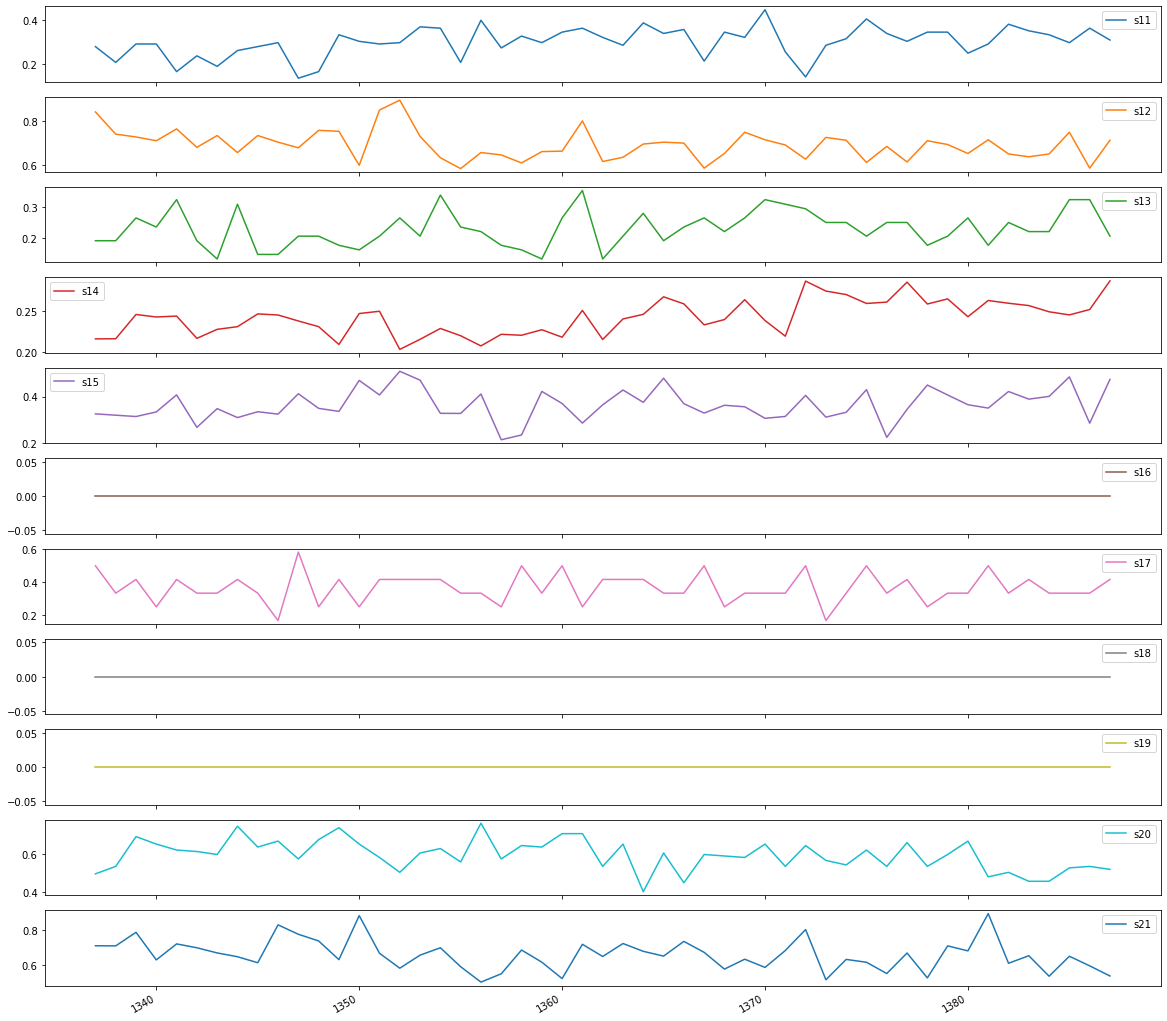

In [174]:
# plotting sensor data for engine ID 3 prior to a failure point - sensors 11-21 
ax2 = engine_id12_50cycleWindow2.plot(subplots=True, sharex=True, figsize=(20,20))

In [175]:
# pick a large window size of 50 cycles
sequence_length = 50

In [176]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [177]:
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

In [178]:
# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

In [179]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(15631, 50, 25)

In [180]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [181]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

In [182]:
# In order to compare the results to the template, we pick the last sequence for each id in the test data.
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]

label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

In [183]:
print(seq_array_test_last.shape)
print(label_array_test_last.shape)

(93, 50, 25)
(93, 1)


# LTSM Model

In [184]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [185]:
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50, 100)           50400     
                                                                 
 dropout_12 (Dropout)        (None, 50, 100)           0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_13 (Dropout)        (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
None


In [186]:
%%time
# fit the network
history = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
                                    # callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')]
                                    )

Epoch 1/10
75/75 [==============================] - 22s 247ms/step - loss: 0.2708 - accuracy: 0.8803 - val_loss: 0.1064 - val_accuracy: 0.9616
Epoch 2/10
75/75 [==============================] - 18s 235ms/step - loss: 0.1093 - accuracy: 0.9555 - val_loss: 0.0507 - val_accuracy: 0.9847
Epoch 3/10
75/75 [==============================] - 18s 236ms/step - loss: 0.0850 - accuracy: 0.9650 - val_loss: 0.0727 - val_accuracy: 0.9744
Epoch 4/10
75/75 [==============================] - 18s 237ms/step - loss: 0.0827 - accuracy: 0.9662 - val_loss: 0.0636 - val_accuracy: 0.9719
Epoch 5/10
75/75 [==============================] - 18s 236ms/step - loss: 0.0689 - accuracy: 0.9714 - val_loss: 0.0571 - val_accuracy: 0.9731
Epoch 6/10
75/75 [==============================] - 18s 238ms/step - loss: 0.0688 - accuracy: 0.9710 - val_loss: 0.0593 - val_accuracy: 0.9719
Epoch 7/10
75/75 [==============================] - 18s 236ms/step - loss: 0.0627 - accuracy: 0.9737 - val_loss: 0.0382 - val_accuracy: 0.9834

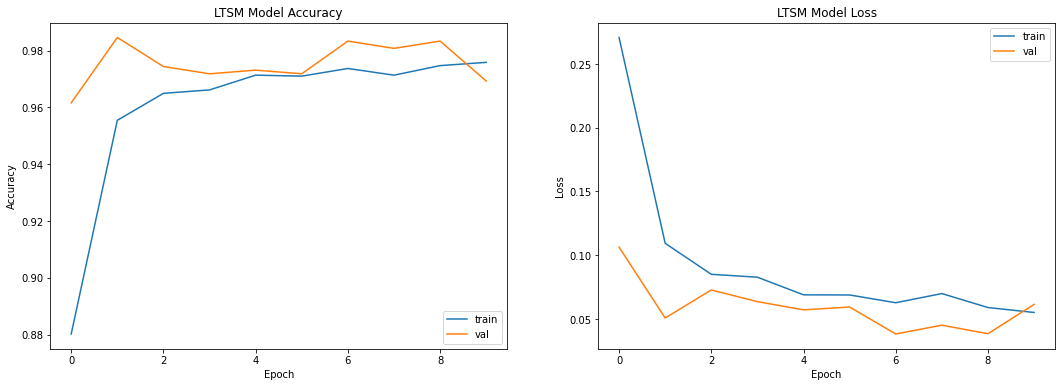

In [187]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
ax1= plt.plot(history.history['accuracy'], label='train')
ax2= plt.plot(history.history['val_accuracy'], label='val')
plt.title('LTSM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
ax1= plt.plot(history.history['loss'], label='train')
ax2= plt.plot(history.history['val_loss'], label='val')
plt.title('LTSM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [188]:
# make predictions and compute confusion matrix
y_pred = (model.predict(seq_array,verbose=1, batch_size=200) > 0.5).astype("int32")
y_true = label_array
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

79/79 [==============================] - 7s 82ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[12516,    15],
       [  438,  2662]])

In [189]:
# training metrics
train_scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(train_scores[1]))

79/79 [==============================] - 7s 82ms/step - loss: 0.0658 - accuracy: 0.9710
Accurracy: 0.9710191488265991


In [190]:
# make predictions and compute confusion matrix
y_pred_test = (model.predict(seq_array_test_last) > 0.5).astype("int32")
y_true_test = label_array_test_last
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
cm

Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[68,  0],
       [ 4, 21]])

In [191]:
# test metrics
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

3/3 - 0s - loss: 0.0974 - accuracy: 0.9570 - 67ms/epoch - 22ms/step
Accurracy: 0.9569892287254333


In [192]:
# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Precision:  1.0 
 Recall:  0.84 
 F1-score: 0.9130434782608696


In [193]:
ltsm_df = pd.DataFrame([['00:05:21',scores_test[1],precision_test,recall_test,f1_test]],
                         columns = ['Time', 'Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['LSTM 100/50'])
ltsm_df

,Time,Accuracy,Precision,Recall,F1-score
LSTM 100/50,00:05:21,0.956989,1.0,0.84,0.913043


#GRU Model

In [194]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(GRU(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [195]:
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 50, 100)           38100     
                                                                 
 dropout_14 (Dropout)        (None, 50, 100)           0         
                                                                 
 gru_5 (GRU)                 (None, 50)                22800     
                                                                 
 dropout_15 (Dropout)        (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 60,951
Trainable params: 60,951
Non-trainable params: 0
_________________________________________________________________
None


In [196]:
%%time
# fit the network
history = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
                                    # callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')]
                                    )

Epoch 1/10
75/75 [==============================] - 21s 225ms/step - loss: 0.2476 - accuracy: 0.8968 - val_loss: 0.1557 - val_accuracy: 0.9297
Epoch 2/10
75/75 [==============================] - 16s 214ms/step - loss: 0.1220 - accuracy: 0.9490 - val_loss: 0.0777 - val_accuracy: 0.9680
Epoch 3/10
75/75 [==============================] - 16s 215ms/step - loss: 0.0919 - accuracy: 0.9596 - val_loss: 0.0638 - val_accuracy: 0.9719
Epoch 4/10
75/75 [==============================] - 16s 215ms/step - loss: 0.0645 - accuracy: 0.9730 - val_loss: 0.0802 - val_accuracy: 0.9616
Epoch 5/10
75/75 [==============================] - 16s 217ms/step - loss: 0.0678 - accuracy: 0.9712 - val_loss: 0.0603 - val_accuracy: 0.9706
Epoch 6/10
75/75 [==============================] - 16s 219ms/step - loss: 0.0540 - accuracy: 0.9764 - val_loss: 0.0571 - val_accuracy: 0.9757
Epoch 7/10
75/75 [==============================] - 16s 215ms/step - loss: 0.0540 - accuracy: 0.9770 - val_loss: 0.0636 - val_accuracy: 0.9731

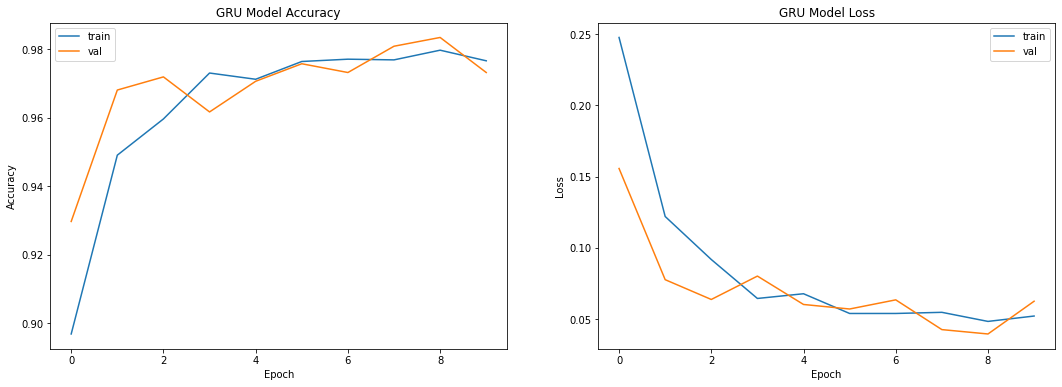

In [197]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
ax1= plt.plot(history.history['accuracy'], label='train')
ax2= plt.plot(history.history['val_accuracy'], label='val')
plt.title('GRU Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
ax1= plt.plot(history.history['loss'], label='train')
ax2= plt.plot(history.history['val_loss'], label='val')
plt.title('GRU Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [198]:
# make predictions and compute confusion matrix
y_pred = (model.predict(seq_array,verbose=1, batch_size=200) > 0.5).astype("int32")
y_true = label_array
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

79/79 [==============================] - 6s 67ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[12482,    49],
       [  318,  2782]])

In [199]:
# training metrics
train_scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(train_scores[1]))

79/79 [==============================] - 5s 67ms/step - loss: 0.0538 - accuracy: 0.9765
Accurracy: 0.9765210151672363


In [200]:
# make predictions and compute confusion matrix
y_pred_test = (model.predict(seq_array_test_last) > 0.5).astype("int32")
y_true_test = label_array_test_last
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
cm

Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[68,  0],
       [ 3, 22]])

In [201]:
# test metrics
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

3/3 - 0s - loss: 0.0637 - accuracy: 0.9677 - 59ms/epoch - 20ms/step
Accurracy: 0.9677419066429138


In [202]:
# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Precision:  1.0 
 Recall:  0.88 
 F1-score: 0.9361702127659575


In [203]:
gru_df = pd.DataFrame([['00:04:55',scores_test[1],precision_test,recall_test,f1_test]],
                         columns = ['Time', 'Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['GRU 100/50'])
gru_df

,Time,Accuracy,Precision,Recall,F1-score
GRU 100/50,00:04:55,0.967742,1.0,0.88,0.93617


#RNN Model

In [204]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(SimpleRNN(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(SimpleRNN(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [205]:
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 50, 100)           12600     
                                                                 
 dropout_16 (Dropout)        (None, 50, 100)           0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 50)                7550      
                                                                 
 dropout_17 (Dropout)        (None, 50)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
Total params: 20,201
Trainable params: 20,201
Non-trainable params: 0
_________________________________________________________________
None


In [206]:
%%time
# fit the network
history = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
                                    # callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')]
                                    )

Epoch 1/10
75/75 [==============================] - 8s 81ms/step - loss: 0.2096 - accuracy: 0.9131 - val_loss: 0.1761 - val_accuracy: 0.9335
Epoch 2/10
75/75 [==============================] - 6s 77ms/step - loss: 0.1207 - accuracy: 0.9495 - val_loss: 0.0815 - val_accuracy: 0.9565
Epoch 3/10
75/75 [==============================] - 6s 76ms/step - loss: 0.1166 - accuracy: 0.9506 - val_loss: 0.1021 - val_accuracy: 0.9463
Epoch 4/10
75/75 [==============================] - 6s 76ms/step - loss: 0.0965 - accuracy: 0.9601 - val_loss: 0.0867 - val_accuracy: 0.9540
Epoch 5/10
75/75 [==============================] - 6s 77ms/step - loss: 0.0958 - accuracy: 0.9601 - val_loss: 0.0661 - val_accuracy: 0.9693
Epoch 6/10
75/75 [==============================] - 6s 77ms/step - loss: 0.0909 - accuracy: 0.9615 - val_loss: 0.0697 - val_accuracy: 0.9731
Epoch 7/10
75/75 [==============================] - 6s 76ms/step - loss: 0.0753 - accuracy: 0.9692 - val_loss: 0.0576 - val_accuracy: 0.9770
Epoch 8/10
75

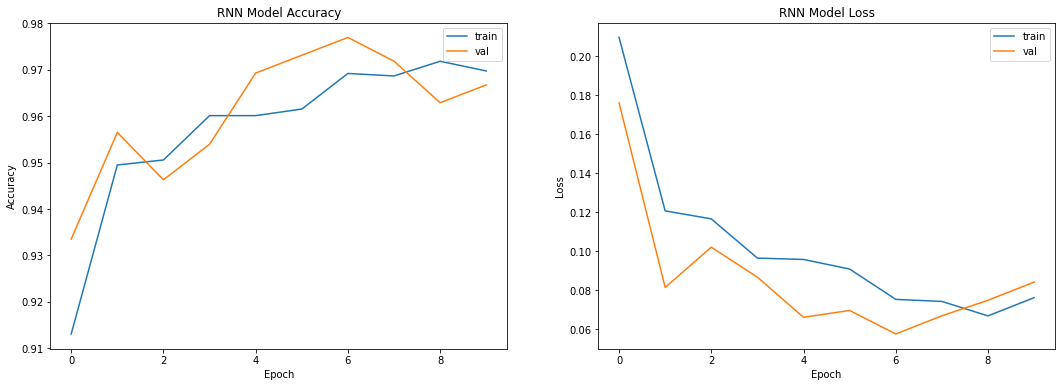

In [207]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
ax1= plt.plot(history.history['accuracy'], label='train')
ax2= plt.plot(history.history['val_accuracy'], label='val')
plt.title('RNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
ax1= plt.plot(history.history['loss'], label='train')
ax2= plt.plot(history.history['val_loss'], label='val')
plt.title('RNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [208]:
# make predictions and compute confusion matrix
y_pred = (model.predict(seq_array,verbose=1, batch_size=200) > 0.5).astype("int32")
y_true = label_array
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

79/79 [==============================] - 2s 26ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[12161,   370],
       [   90,  3010]])

In [209]:
# training metrics
train_scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(train_scores[1]))

79/79 [==============================] - 2s 27ms/step - loss: 0.0678 - accuracy: 0.9706
Accurracy: 0.9705712795257568


In [210]:
# make predictions and compute confusion matrix
y_pred_test = (model.predict(seq_array_test_last) > 0.5).astype("int32")
y_true_test = label_array_test_last
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
cm

Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[65,  3],
       [ 2, 23]])

In [211]:
# test metrics
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

3/3 - 0s - loss: 0.1178 - accuracy: 0.9462 - 38ms/epoch - 13ms/step
Accurracy: 0.9462365508079529


In [212]:
# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Precision:  0.8846153846153846 
 Recall:  0.92 
 F1-score: 0.9019607843137256


In [213]:
rnn_df = pd.DataFrame([['00:01:44',scores_test[1],precision_test,recall_test,f1_test]],
                         columns = ['Time', 'Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['RNN 100/50'])
rnn_df

,Time,Accuracy,Precision,Recall,F1-score
RNN 100/50,00:01:44,0.946237,0.884615,0.92,0.901961


In [214]:
# Overall CPU results
pd.concat([ltsm_df, gru_df, rnn_df])

,Time,Accuracy,Precision,Recall,F1-score
LSTM 100/50,00:05:21,0.956989,1.000000,0.84,0.913043
GRU 100/50,00:04:55,0.967742,1.000000,0.88,0.936170
RNN 100/50,00:01:44,0.946237,0.884615,0.92,0.901961


In [ ]:
# Overall GPU results
pd.concat([ltsm_df, gru_df, rnn_df])

,Time,Accuracy,Precision,Recall,F1-score
LSTM 100/50,00:00:26,0.967742,0.958333,0.92,0.938776
GRU 100/50,00:00:25,0.978495,0.960000,0.96,0.960000
RNN 100/50,00:02:30,0.978495,1.000000,0.92,0.958333
